In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [3]:
import gymnasium as gym

env = gym.make("CartPole-v1", render_mode="rgb_array")
env.reset()

(array([0.0135043 , 0.01744082, 0.01535558, 0.03817197], dtype=float32), {})

Each observation is a 1D NumPy array containing 4 floats representing:
- the cart's horizontal position (0.0 = center)
- its velocity (+ means right)
- angle of the pole (0.0 = vertical)
- angular velocity (+ means clockwise)

`reset()` also returns a dictionary with environment-specific information.

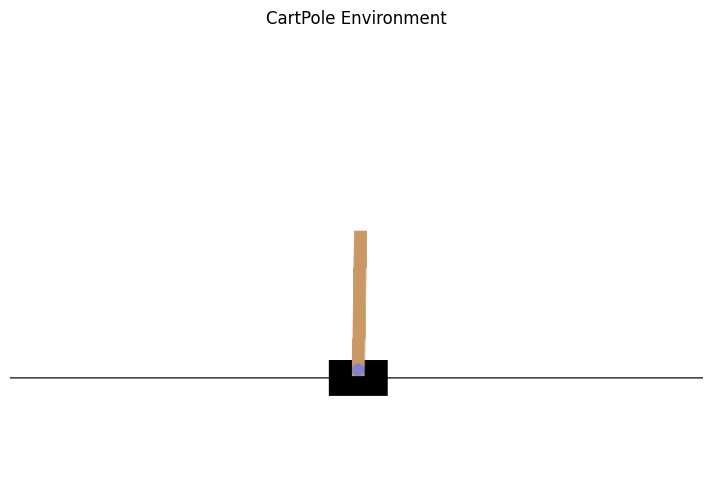

In [4]:
img = env.render()

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.imshow(img)
plt.axis('off')
plt.title('CartPole Environment')
plt.show()


In [5]:
env.action_space

Discrete(2)

Two possible actions noted by integers 0 and 1, representing accelerating left or right. 

In [6]:
action = 1
obs, reward, done, truncated, info = env.step(action)

In [7]:
obs, reward, done, truncated, info

(array([ 0.01385312,  0.21233924,  0.01611902, -0.24962685], dtype=float32),
 1.0,
 False,
 False,
 {})

- `obs` is the new observation.
- `reward` is 1.0 at every step, no matter what you do, so goal is to keep it running as long as possible
- `done` is `True` when the episode is over (when pole tilts too much, goes off the screen, or in 200 steps - you win). Then you have to reset.
- `truncated` is `True` when an episode is interrupted early
- `info` for env specific dictionary with extra info

In [8]:
def basic_policy(obs):
    angle = obs[2]
    return 0 if angle < 0 else 1


totals = []
for episode in range(500):
    episode_rewards = 0
    obs, info = env.reset(seed=episode)
    for step in range(200):
        action = basic_policy(obs)
        obs, reward, done, truncated, info = env.step(action)
        episode_rewards += reward
        if done or truncated:
            break

    totals.append(episode_rewards)

In [9]:
np.mean(totals), np.std(totals), min(totals), max(totals)

(41.698, 8.389445512070509, 24.0, 63.0)

In [10]:
import matplotlib 
import matplotlib.animation
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)
plt.rc('animation', html='jshtml')

def update_scene(num, frames, patch):
    patch.set_data(frames[num])
    return patch,

def plot_animation(frames, repeat=False, interval=40):
    fig = plt.figure()
    patch = plt.imshow(frames[0])
    plt.axis('off')
    anim = matplotlib.animation.FuncAnimation(
        fig, update_scene, fargs=(frames, patch),
        frames=len(frames), repeat=repeat, interval=interval)
    plt.close()
    return anim

def show_one_episode(policy, n_max_steps=200, seed=42):
    frames = []
    env = gym.make("CartPole-v1", render_mode="rgb_array")
    np.random.seed(seed)
    obs, info = env.reset(seed=seed)
    for step in range(n_max_steps):
        frames.append(env.render())
        action = policy(obs)
        obs, reward, done, truncated, info = env.step(action)
        if done or truncated:
            break
    env.close()
    print(len(frames))
    return plot_animation(frames)

show_one_episode(basic_policy)

55


In [11]:
model = nn.Sequential(
    nn.Linear(4, 5),
    nn.ReLU(),
    nn.Linear(5, 1),
    nn.Sigmoid()
)

In [12]:
def play_one_step(env, obs, model, loss_fn):
    # Reshape so it becomes a batch with one instance
    obs_tensor = torch.tensor(obs[np.newaxis], dtype=torch.float32)
    
    left_proba = model(obs_tensor).detach()
    action = (torch.rand(1, 1) > left_proba).int()
    y_target = torch.tensor([[1.0]]) - action.float()
    
    loss = loss_fn(left_proba, y_target)
    
    # Compute gradients
    loss.backward()
    
    # Collect gradients
    grads = [param.grad for param in model.parameters()]
    
    # Take the action in the environment
    obs, reward, done, truncated, info = env.step(int(action.item()))
    
    return obs, reward, done, truncated, grads

In [13]:
def play_multiple_episodes(env, n_episodes, n_max_steps, model, loss_fn):
    """
    Returns a tuple of:
     - a list of reward lists: one reward list per episode that contains one reward per step.
     - a list of gradient lists: one gradient list per episode, each with one tuple of gradients per step, and each tuple containing one gradient tensor per trainable variable
    """
    all_rewards = []
    all_grads = []
    for episode in range(n_episodes):
        current_rewards = []
        current_grads = []
        obs, info = env.reset()
        for step in range(n_max_steps):
            obs, reward, done, truncated, grads = play_one_step(
                env, obs, model, loss_fn
            )
            current_rewards.append(reward)
            current_grads.append(grads)
            if done or truncated:
                break
        
        all_rewards.append(current_rewards)
        all_grads.append(current_grads)

    return all_rewards, all_grads

In [14]:
def discounted_rewards(rewards, discount_factor):
    discounted = np.array(rewards)
    for step in range(len(rewards) - 2, -1, -1):
        discounted[step] += discounted[step + 1] * discount_factor
    return discounted

def discount_and_normalize_rewards(all_rewards, discount_factor):
    all_discounted_rewards = [discounted_rewards(rewards, discount_factor) for rewards in all_rewards]
    flat_rewards = np.concatenate(all_discounted_rewards)
    reward_mean = flat_rewards.mean()
    reward_std = flat_rewards.std()
    return [(discounted_rewards - reward_mean) / reward_std for discounted_rewards in all_discounted_rewards]


In [15]:
n_iterations = 150
n_episodes_per_update = 10
n_max_steps = 200
discount_factor = 0.95

In [ ]:
# Define a new policy function that uses the trained model
def model_policy(obs):
    obs_tensor = torch.tensor(obs[np.newaxis], dtype=torch.float32)
    left_proba = model(obs_tensor)
    print(left_proba)
    action = (left_proba < 0.5).int().item()
    return action

# Show an episode using the trained model
anim = show_one_episode(model_policy)
anim

tensor([[0.4117]], grad_fn=<SigmoidBackward0>)
tensor([[0.4115]], grad_fn=<SigmoidBackward0>)
tensor([[0.4115]], grad_fn=<SigmoidBackward0>)
tensor([[0.4117]], grad_fn=<SigmoidBackward0>)
tensor([[0.4109]], grad_fn=<SigmoidBackward0>)
tensor([[0.4098]], grad_fn=<SigmoidBackward0>)
tensor([[0.4090]], grad_fn=<SigmoidBackward0>)
tensor([[0.4084]], grad_fn=<SigmoidBackward0>)
tensor([[0.4099]], grad_fn=<SigmoidBackward0>)
tensor([[0.4117]], grad_fn=<SigmoidBackward0>)


In [29]:
learning_rate = 0.01
gamma = 0.99  # Discount factor for future rewards

In [30]:
class PolicyNetwork(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(PolicyNetwork, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return self.softmax(x)

input_dim = env.observation_space.shape[0]
hidden_dim = 128
output_dim = env.action_space.n

In [31]:
# model = PolicyNetwork(input_dim, hidden_dim, output_dim)

model = nn.Sequential(
    nn.Linear(input_dim, hidden_dim),
    nn.ReLU(),
    nn.Linear(hidden_dim, output_dim),
    nn.Softmax(dim=-1)
)

optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [32]:
def select_action(model, state):
    state = torch.from_numpy(state).float()
    probs = model(state)
    action = np.random.choice(len(probs.detach().numpy()), p=probs.detach().numpy())
    return action, probs[action]

def compute_discounted_rewards(rewards, gamma):
    discounted_rewards = []
    R = 0
    for r in reversed(rewards):
        R = r + gamma * R
        discounted_rewards.insert(0, R)
    return discounted_rewards

def train(env, model, optimizer, num_episodes=1000):
    for episode in range(num_episodes):
        state, info = env.reset()
        log_probs = []
        rewards = []
        for t in range(1000):  # max steps per episode
            action, prob = select_action(model, state)
            state, reward, done, truncated, info = env.step(action)
            log_probs.append(torch.log(prob))
            rewards.append(reward)
            if done or truncated:
                break

        discounted_rewards = compute_discounted_rewards(rewards, gamma)
        discounted_rewards = torch.tensor(discounted_rewards)

        # Normalize (add small constant to ensure no div by zero)
        discounted_rewards = (discounted_rewards - discounted_rewards.mean()) / (discounted_rewards.std() + 1e-9)

        policy_gradient = []
        for prob, reward in zip(log_probs, discounted_rewards):
			# Multiply log probability by the corresponding normalized reward (advantage)
			# This scales the gradient by how good or bad the action turned out to be
            policy_gradient.append(-prob * reward)
        policy_gradient = torch.stack(policy_gradient).sum()  # result is total gradient for the episode


        optimizer.zero_grad()
        policy_gradient.backward()
        optimizer.step()

        if episode % 100 == 0:
            print(f"Episode {episode}\tTotal Reward: {sum(rewards)}")

In [33]:
train(env, model, optimizer)

Episode 0	Total Reward: 30.0


Episode 100	Total Reward: 123.0
Episode 200	Total Reward: 182.0
Episode 300	Total Reward: 113.0
Episode 400	Total Reward: 80.0
Episode 500	Total Reward: 103.0
Episode 600	Total Reward: 131.0
Episode 700	Total Reward: 500.0
Episode 800	Total Reward: 252.0
Episode 900	Total Reward: 302.0


In [34]:
# Define a new policy function that uses the trained model
def model_policy(obs):
    obs_tensor = torch.tensor(obs[np.newaxis], dtype=torch.float32)
    left_proba = model(obs_tensor)
    print(left_proba)
    action = (left_proba[0][0] < 0.5).int().item()
    return action

# Show an episode using the trained model
anim = show_one_episode(model_policy)
anim

tensor([[0.0054, 0.9946]], grad_fn=<SoftmaxBackward0>)
tensor([[0.8377, 0.1623]], grad_fn=<SoftmaxBackward0>)
tensor([[0.0026, 0.9974]], grad_fn=<SoftmaxBackward0>)
tensor([[0.7311, 0.2689]], grad_fn=<SoftmaxBackward0>)
tensor([[0.0013, 0.9987]], grad_fn=<SoftmaxBackward0>)
tensor([[0.6022, 0.3978]], grad_fn=<SoftmaxBackward0>)
tensor([[7.2680e-04, 9.9927e-01]], grad_fn=<SoftmaxBackward0>)
tensor([[0.4673, 0.5327]], grad_fn=<SoftmaxBackward0>)
tensor([[0.9985, 0.0015]], grad_fn=<SoftmaxBackward0>)
tensor([[0.5410, 0.4590]], grad_fn=<SoftmaxBackward0>)
tensor([[6.5134e-04, 9.9935e-01]], grad_fn=<SoftmaxBackward0>)
tensor([[0.4982, 0.5018]], grad_fn=<SoftmaxBackward0>)
tensor([[0.9989, 0.0011]], grad_fn=<SoftmaxBackward0>)
tensor([[0.6616, 0.3384]], grad_fn=<SoftmaxBackward0>)
tensor([[0.0013, 0.9987]], grad_fn=<SoftmaxBackward0>)
tensor([[0.7082, 0.2918]], grad_fn=<SoftmaxBackward0>)
tensor([[0.0017, 0.9983]], grad_fn=<SoftmaxBackward0>)
tensor([[0.7599, 0.2401]], grad_fn=<SoftmaxBackwa